In [255]:
%load_ext autoreload
%autoreload 2

import sys
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## EVALUATING AGAINST NERDD DATA

In [256]:
import os
# Setting env variables
os.environ['CXRDATA']='/dfs/scratch0/jdunnmon/data/mmtl/cxr'
os.environ['CXR8IMAGES']='/lfs/1/jdunnmon/data/nih/images/images_heq'
os.environ['NERDDIMAGES']='/lfs/1/jdunnmon/cxr/data/nerdd/preproc_224_cxr_h5'

In [257]:
from metal.mmtl.cxr.analysis.notebooks.cxr_analysis import load_log_json, load_results_from_log
from metal.mmtl.cxr.cxr_tasks import create_tasks_and_payloads
# Loading results from model log
model_log = '/lfs/1/jdunnmon/repos/metal/logs/2019_05_17/nerdd_chest_tube_02_12_26/'
log_jsons = load_results_from_log(model_log)

In [258]:
task_config = log_jsons['task_config']
nerdd_tasks, nerdd_payloads = create_tasks_and_payloads([task_config['tasks']], **task_config, batch_size=16)

metal.utils - INFO - Could not find kwarg "attention" in destination dict.
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
metal.mmtl.cxr.cxr_tasks - INFO - Loading NERDD-CHEST-TUBE Dataset
metal.mmtl.cxr.cxr_tasks - INFO - Using train finding CHEST_TUBE
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
metal.mmtl.cxr.cxr_datasets - INFO - Transforming labels for NERDD_LABEL class
metal.mmtl.cxr.cxr_datasets - INFO - Transforming labels for NERDD_LABEL class
metal.mmtl.cxr.cxr_tasks - INFO - Using imbalanced_sampler sampler for training split...


In [5]:
nerdd_tasks[0].scorer.metrics

['f1', 'roc-auc', 'accuracy', 'precision', 'recall']

In [6]:
from metal.mmtl.metal_model import MetalModel
import torch
# Initializing the model
model_config = log_jsons['model_config'] 
model = torch.load(os.path.join(model_log,'model.pkl'))
#model_config.update({'model_weights': os.path.join(model_log,'best_model.pth')})
#model = MetalModel(tasks=nerdd_tasks, **model_config)

In [22]:
# Resetting model to access new 
model.task_map['NERDD-CHEST-TUBE_CHEST_TUBE'] = nerdd_tasks[0]

In [23]:
train_payload, dev_payload, test_payload = nerdd_payloads
metrics = ['NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/f1',
           'NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/precision',
           'NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/recall',
           'NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/accuracy',
           'NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/roc-auc', 
]
metrics_dict = model.score(test_payload, metrics=metrics)

In [24]:
metrics_dict

{'NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/f1': 0.7238302502720348,
 'NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/roc-auc': 0.9431975156321124,
 'NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/accuracy': 0.9395282344531808,
 'NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/precision': 0.7016877637130802,
 'NERDD-CHEST-TUBE_CHEST_TUBE/NERDD-CHEST-TUBE_CHEST_TUBE_test/NERDD-CHEST-TUBE_CHEST_TUBE/recall': 0.7474157303370786}

## EVALUATING AGAINST CHEXNET DEV DATA

In [106]:
# Evaluate drains vs. normals

In [107]:
import copy
from metal.mmtl.cxr.cxr_tasks import create_tasks_and_payloads
task_config_cxr8 = copy.deepcopy(task_config)
task_config_cxr8.update({
    'splits':['train','valid','test'],
    'tasks':'CXR8_ALL',
    'active_slice_heads':{'ind':True, 'pred':False},
    'slice_dict':{'CXR8_PNEUMOTHORAX':['chest_drain_nerdd_cnn_pos']},
    "train_sampler":None,
})
cxr8_tasks, cxr8_payloads = create_tasks_and_payloads([task_config_cxr8['tasks']], **task_config_cxr8, batch_size=16)

metal.utils - INFO - Could not find kwarg "attention" in destination dict.
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
metal.mmtl.cxr.cxr_tasks - INFO - Loading CXR8 Dataset
metal.mmtl.cxr.cxr_tasks - INFO - Using train finding ALL
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
metal.mmtl.cxr.cxr_tasks - INFO - Shuffling training split...
metal.mmtl.payload - INFO - Added label_set with 78468/78468 labels for task CXR8_PNEUMOTHORAX_slice:chest_drain_nerdd_cnn_pos:ind to payload CXR8_train.
metal.mmtl.payload - INFO - Added label_set with 11219/11219 labels for task CXR8_PNEUMOTHORAX

In [131]:
eval_payload = cxr8_payloads[1]
tasks_to_remove = [t for t in eval_payload.labels_to_tasks.keys() if 'slice' not in t]
_ = [eval_payload.remove_label_set(t) for t in tasks_to_remove]
eval_payload.remap_labelsets({'CXR8_PNEUMOTHORAX_slice:chest_drain_nerdd_cnn_pos:ind':'NERDD-CHEST-TUBE_CHEST_TUBE'})
eval_dataset = eval_payload.data_loader.dataset

In [132]:
sum(eval_dataset.labels['CXR8_PNEUMOTHORAX_slice:chest_drain_nerdd_cnn_pos:ind']==2)

10919

In [99]:
# Should be 300 and 672
model.score(eval_payload)

{'NERDD-CHEST-TUBE_CHEST_TUBE/CXR8_valid/CXR8_PNEUMOTHORAX_slice:chest_drain_nerdd_cnn_pos:ind/f1': 0.04155844155844156,
 'NERDD-CHEST-TUBE_CHEST_TUBE/CXR8_valid/CXR8_PNEUMOTHORAX_slice:chest_drain_nerdd_cnn_pos:ind/roc-auc': 0.7578077968067893,
 'NERDD-CHEST-TUBE_CHEST_TUBE/CXR8_valid/CXR8_PNEUMOTHORAX_slice:chest_drain_nerdd_cnn_pos:ind/accuracy': 0.9671093680363668,
 'NERDD-CHEST-TUBE_CHEST_TUBE/CXR8_valid/CXR8_PNEUMOTHORAX_slice:chest_drain_nerdd_cnn_pos:ind/precision': 0.09411764705882353,
 'NERDD-CHEST-TUBE_CHEST_TUBE/CXR8_valid/CXR8_PNEUMOTHORAX_slice:chest_drain_nerdd_cnn_pos:ind/recall': 0.02666666666666667}

In [111]:
Ys, Ys_probs, Ys_preds, Ys_meta = model.predict_with_gold(
            eval_payload, None, None, 
            return_preds=True, return_meta=['uid'])

In [211]:
import pandas as pd
df = pd.DataFrame({'uid':Ys_meta['uid'],
                   'probs':[a[0] for a in Ys_probs['NERDD-CHEST-TUBE_CHEST_TUBE']],
                   'preds': Ys_preds['NERDD-CHEST-TUBE_CHEST_TUBE'],
                   'true': Ys['CXR8_PNEUMOTHORAX_slice:chest_drain_nerdd_cnn_pos:ind'],
                  }
                   )

Prob: 0.04005179554224014, Prediction: 2, Truth: 1, UID: 00000758_002.png


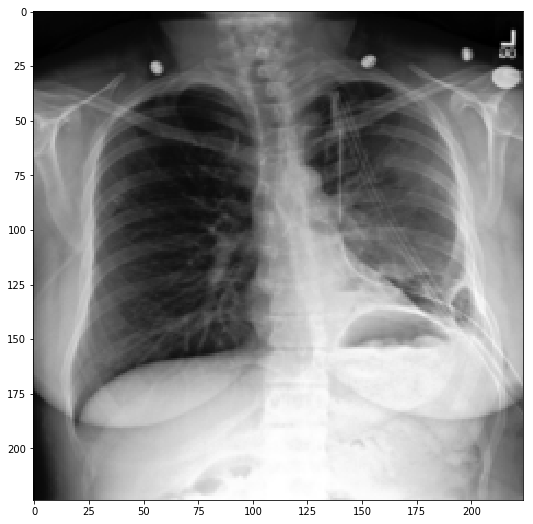

In [253]:
# Getting pred and data entries
### INDEX TO CHECK FOR POSITIVE EXAMPLES
df_viz = df[df['true']==1]
ind = 9

### PLOTTING AND PRINTING
pred_entry = df_viz.iloc[ind]
uid = pred_entry.uid
orig_entry = eval_dataset.df.loc[uid]
ds_ind = eval_dataset.df.index.tolist().index(uid)
data_entry = eval_dataset[ds_ind]
assert(uid==orig_entry.name)
assert(orig_entry.name == data_entry[0]['uid'])
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9))
plt.imshow(data_entry[0]['data'][0,:,:], cmap='gray')
print(f"Prob: {pred_entry['probs']}, Prediction: {pred_entry['preds']}, Truth: {int(pred_entry['true'])}, UID: {pred_entry['uid']}")

In [235]:
import torch
torch.argmax(torch.Tensor(df_viz['probs'].tolist()))

tensor(8535)

In [229]:
torch.max(torch.Tensor(df_viz['probs'].tolist()))

tensor(0.9274)

In [222]:
max(df_viz['probs'])

0.9274000525474548

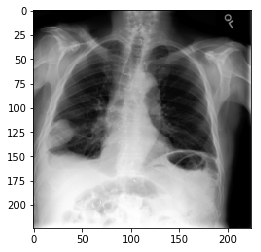

In [84]:
import matplotlib.pyplot as plt
img = eval_payload.data_loader.dataset[0][0]['data'][0,:,:]
plt.imshow(eval_payload.data_loader.dataset[0][0]['data'][0,:,:], cmap='gray')

(array([8169., 4713., 4715., 4712., 4476., 4765., 4720., 4405., 4586.,
        4915.]),
 array([-1.5135653 , -1.1879174 , -0.86226934, -0.53662133, -0.21097335,
         0.11467463,  0.4403226 ,  0.7659706 ,  1.0916185 ,  1.4172666 ,
         1.7429146 ], dtype=float32),
 <a list of 10 Patch objects>)

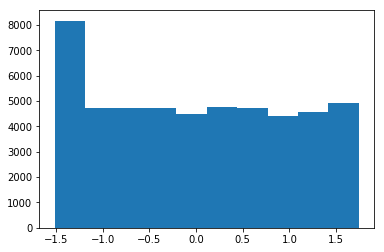

In [85]:
plt.hist(img.flatten())